In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx import NetworkXNoPath
import matplotlib.pyplot as plt
import math
import time
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
import collections
import random

In [2]:
df=pd.read_csv("traffic_uniform.csv", delimiter=",", header=None)
df1 = pd.read_csv("traffic_complement.csv", delimiter=",", header=None)
df2 = pd.read_csv("traffic_rand.csv", delimiter=",", header=None)
uniform=df.to_numpy()
complement=df1.to_numpy()
rand=df2.to_numpy()

In [3]:
#adjacency_matrix=np.ones(shape=(64,64))
#np.fill_diagonal(adjacency_matrix,0)
#G=nx.Di
#print(Task_matrix)
#mesh_adjacency=[]
def mesh_generation():
    Links=[]
    for i in range(63):
        if i in [56,57,58,59,60,61,62]:
            Links.append([i,i+1])
        elif i in [7,15,23,31,39,47,55]:
            Links.append([i,i+8])    
        else:
            Links.append([i,i+1])
            Links.append([i,i+8])
    #print (Links)        
    return Links
#Links=mesh_generation()
def adjacency_matrix(Links):
    adjacency_matrix=np.zeros(shape=(64,64))
    np.fill_diagonal(adjacency_matrix,0)
    for link in Links:
        adjacency_matrix[[link[0]],[link[1]]]=1
        adjacency_matrix[[link[1]],[link[0]]]=1
    #print(adjacency_matrix)
    return adjacency_matrix
#adjacency_matrix(Links)
def hop_count(adjacency):
    hopcount=np.zeros(shape=(64,64))
    adjacency_matrix=nx.from_numpy_matrix(adjacency, create_using=nx.DiGraph())
    for i in range(64):
        for j in range(64):
            hopcount[i][j]=nx.shortest_path_length(adjacency_matrix,i,j)
    return hopcount

def perturb(Scurr, Tcurr, path_length):
    link_or_tile=random.randint(0,1)
    Source_core=random.randint(0,63)
    Dest_core=random.randint(0,63)
    Snew=deepcopy(Scurr)
    Tnew=deepcopy(Tcurr)
    if (Scurr[Source_core][Dest_core]==1 and Source_core==Dest_core):
        perturb(Scurr, Tcurr, path_length)
    elif (np.sum(Scurr[Source_core])<=1 and np.sum(Scurr[:][Dest_core])<=1):
        perturb(Scurr, Tcurr, path_length)
    elif (np.sum(Scurr[Dest_core])<=1 and np.sum(Scurr[:][Source_core])<=1):
        perturb(Scurr, Tcurr, path_length)
    elif (path_length[Source_core][Dest_core]==0):
        perturb(Scurr, Tcurr, path_length)
    else:
        if(path_length[Source_core][Dest_core]<4 and link_or_tile==0):
            #print(path_length[Source_core][Dest_core])
            Snew = link_move(Source_core, Dest_core, Scurr, Tcurr)
        elif(path_length[Source_core][Dest_core]<4 and link_or_tile==1):
            #print(path_length[Source_core][Dest_core])
            Tnew = tile_swap(Source_core, Dest_core, Tcurr)
        else:
            perturb(Scurr, Tcurr, path_length)
    return Snew,Tnew

def tile_swap(core1, core2, Tcurr):
    Tcurr_copy=deepcopy(Tcurr)
    Tcurr_copy[core1], Tcurr_copy[core2] = Tcurr_copy[core2], Tcurr_copy[core1]
    return Tcurr_copy

def link_move(core1, core2, Scurr, Tcurr):
    Scurr_copy=deepcopy(Scurr)
    path_length=hop_count(Scurr_copy)
    nlinks=np.sum(Scurr_copy[core2])
    core_connect=[]
    coreCount=-1
    if nlinks < 7:
        for i in Scurr_copy[core1]:
            coreCount+=1
            if i==1:
                core_connect.append(coreCount)
        core_link_destroy=random.choice(core_connect)
        if (np.sum(Scurr_copy[core_link_destroy])==1):  
            perturb(Scurr,Tcurr,path_length)
        else:
            Scurr_copy[core1][core_link_destroy]=0
            Scurr_copy[core_link_destroy][core1]=0
            Scurr_copy[core1][core2]=1
            Scurr_copy[core2][core1]=1
    else:
        perturb(Scurr,Tcurr,path_length)
    return Scurr_copy

def get_euclidean():
    euclidean_matrix=np.zeros(shape=(64,64))
    for i in range(64):
        xCoordinate=int(i/8)
        yCoordinate=i%8
        for j in range(64):
            x1Coordinate=int(j/8)
            y1Coordinate=j%8
            xDistance=(x1Coordinate-xCoordinate)**2
            yDistance=(y1Coordinate-yCoordinate)**2
            euclidean_matrix[i][j]=(xDistance+yDistance)**0.5
    euclidean=np.array(euclidean_matrix)
    return euclidean

def get_linklength(Scurr, euclidean):
    linkLength=np.zeros(shape=(64,64))
    length_matrix=np.multiply(Scurr,euclidean)
    link_length=nx.from_numpy_array(length_matrix)
    for i in range(64):
        for j in range(64):
            linkLength[i][j]=nx.shortest_path_length(link_length,i,j)            
    return linkLength

def zero_load_latency(Scurr,hopCount,Task_matrix,Traffic_data):
    cost_vector=[]
    euclidean=get_euclidean()
    linkLength=get_linklength(Scurr, euclidean)
 #   Mesh_link=mesh_generation()
 #   adjacency=adjacency_matrix(Mesh_link)
 #   hopCount=hop_count(adjacency)
    for i in range(64):
        for j in range(64):
            Task=Task_matrix[j]
            cost=(((3*hopCount[i][j]) + math.ceil(linkLength[i][j])) * Traffic_data[Task][i])
            cost_vector.append(cost)
            #print(uniform[Task][j])
    costfinal=np.sum(cost_vector)
    #print(cost)
    return costfinal

def plot(n_vector, curr_vector, Temp_vector):
    fig=plt.figure()
    a1=fig.add_axes([0,0,1,1])
    x=n_vector
    a1.plot(x,curr_vector)
    a1.set_ylabel('Cost')
    a2=a1.twinx()
    a2.plot(x, Temp_vector, color='red')
    a2.set_ylabel('Temperature', color='red')
    fig.legend(labels=('cost', 'Temp'), loc='upper right')
    dia=plt.show()
    return dia

def simulated_Annealing(traffic_data, Scurr, Tcurr, Ccurr):
    T=100
    T_th=0.1
    alpha=0.99
    num_iter=10
    n=0
    n_vector=[]
    Ccurr_vector=[]
    Temp_vector=[]
    Ytrain=[]
    #current_feature1=[]
    path_length=[]
    memoryX=[]
    #memoryY=[]
    hopCount=hop_count(Scurr)
    while T>T_th:
        for i in range(num_iter):
            current_feature=[]
            features=[]
            Sneigh,Tneigh= perturb(Scurr, Tcurr, hopCount)
            Cneigh=zero_load_latency(Sneigh,hopCount,Tneigh,traffic_data)
            if Cneigh<Ccurr:
                Scurr=Sneigh
                Tcurr=Tneigh
                Ccurr=Cneigh
            else:
                accept=math.exp(-(Cneigh-Ccurr)/T)
                if accept > random.uniform(0,1):
                    Tcurr=Tneigh
                    Ccurr=Cneigh
            up_tril=Scurr[np.triu_indices(64, k = 1)]
            input_features=[up_tril,Tcurr]
            # create features vector containing adjacency vector and task vector
            features=[x for y in input_features for x in y]
            for i in features:
                current_feature.append(i)
            memoryX.append(current_feature)
            Ytrain.append(Ccurr)
        T=alpha*T
        Xtrain=np.array(memoryX)
        if n>3:
            if int(Ccurr)==int(Ccurr_vector[n-3]):
                print ("Training_input",Xtrain.shape,"Training_output", len(Ytrain), "no.iterations=",n)
                break
        n_vector.append(n)
        Ccurr_vector.append(Ccurr)
        n+=1 
        Temp_vector.append(T)
        #print("Cost of Design",Ccurr,"Temperature ",T)
    plot(n_vector, Ccurr_vector, Temp_vector)
    #mesh_adjacency=Scurr
    return Scurr, Tcurr, Ccurr, Xtrain, Ytrain 

In [4]:
def STAGE(num_iter, traffic_data, countRepeat, Scurr, Tcurr, Ccurr):
    predict_queue=collections.deque(maxlen=countRepeat)
    predict_queue.clear()
    Scurr,Tcurr,Ccurr,X,y=simulated_Annealing(traffic_data, Scurr, Tcurr, Ccurr)
    hopCount=hop_count(Scurr)
    path_length=[]
    regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
    regressor.fit(X, y)
    Pcurr=Ccurr
    for i in range(num_iter):
        Xtest=[]
        features1=[]   
        # Apply perturb on the last target design
        Sneigh,Tneigh = perturb(Scurr,Tcurr, hopCount)
        # create the test vector of adjacency vector and task vector to provide 
        # input to the regressor for prediction
        up_tril1=Sneigh[np.triu_indices(64, k = 1)]
        input_features1=[up_tril1,Tneigh]
        features1=[x for y in input_features1 for x in y]
        Xtest.append(features1)
        Pneigh = regressor.predict(Xtest)   
        # Minimize the evaluation function of the regressor
        if Pneigh < Pcurr:
            Scurr=Sneigh
            Tcurr=Tneigh
            Pcurr=Pneigh
        predict_queue.append(Pcurr)
        # Stopping condition if the prediction values do not change for given number of repeats
        if len(predict_queue)==countRepeat:
            predict_val=predict_queue[0]
            min_predictVal=predict_val-100
            max_predictVal=predict_val+100
            countP=0
            for i in range(len(predict_queue)):
                if (min_predictVal < predict_queue[i]) and (max_predictVal > predict_queue[i]):
                    countP=countP+1
            if countP==countRepeat:
                Pcurr = predict_queue[countRepeat-1]
                break
    return Scurr, Tcurr, Pcurr    

In [5]:
def callStage(traffic_data,numIter,countRepeat):
    
    '''This function calls stage recursively'''
    start=time.time()
    cost_queue=[]
    Mesh_link=mesh_generation()
    Scurr=adjacency_matrix(Mesh_link)
    Tcurr= [i for i in range(64)]
    hopCount=hop_count(Scurr)
    Ccurr=zero_load_latency(Scurr,hopCount,Tcurr,traffic_data)
    print("Cost function for Mesh",Ccurr) 
    for i in range(numIter):
        # memoryX and memoryY is appended for each iteration with the previous data and the last design 
        # is fed as base to the new design
        Scurr, Tcurr, Ccurr=STAGE(numIter, traffic_data, countRepeat, Scurr, Tcurr, Ccurr)
        Scurr=Scurr
        Tcurr=Tcurr
        Ccurr=Ccurr
        # stopping condition for Stage
        print("Cost Value after Stage",Ccurr)
        if len(cost_queue)==countRepeat:
            break
        if i>1:
            if int(Ccurr)==int(cost_queue[i-1]):
                break
            elif int(Ccurr)-int(cost_queue[i-1])<=countRepeat:
                break
        cost_queue.append(Ccurr)    
    end=time.time()
    print("Total Execution Time:",end-start)
    return Scurr,Tcurr,Ccurr

Cost function for Mesh 43422.86699857061
Training_input (930, 2080) Training_output 930 no.iterations= 92


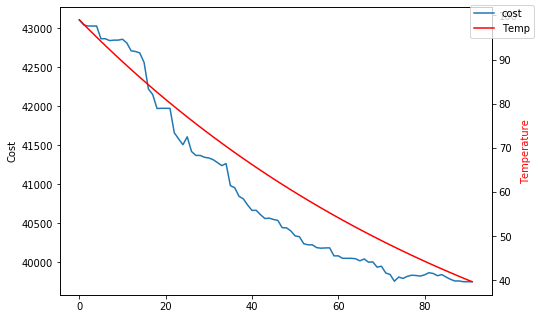

Cost Value after Stage 39750.26633667988
Training_input (1110, 2080) Training_output 1110 no.iterations= 110


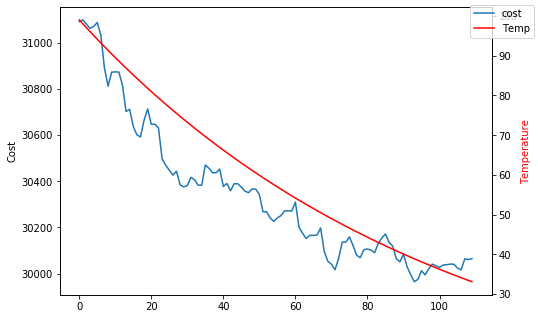

Cost Value after Stage [30063.73406563]
Training_input (800, 2080) Training_output 800 no.iterations= 79


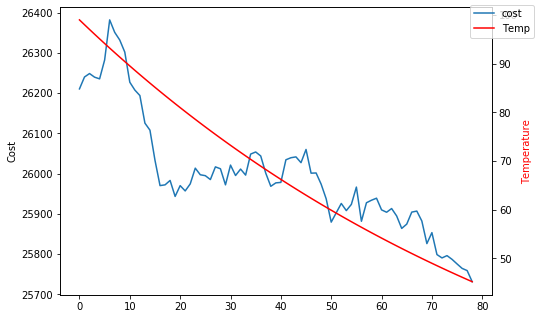

Cost Value after Stage [25757.0769363]
Total Execution Time: 260.32171726226807


In [6]:
Scurr,Tcurr,Ccurr=callStage(rand,1000,10)

[23, 49, 25, 33, 60, 55, 37, 29, 8, 54, 17, 11, 26, 22, 43, 3, 39, 24, 20, 61, 45, 6, 51, 47, 40, 12, 62, 44, 48, 36, 63, 56, 32, 2, 35, 41, 19, 7, 0, 4, 16, 18, 58, 10, 46, 34, 31, 15, 9, 21, 57, 53, 38, 1, 30, 59, 42, 50, 27, 52, 14, 28, 5, 13]


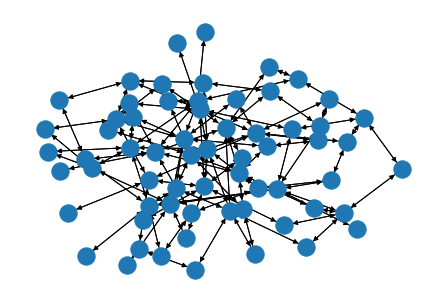

In [13]:
Noc_rand1=nx.from_numpy_matrix(Scurr,create_using=nx.DiGraph())
nx.draw(Noc_rand1,node=True)
print (Tcurr)

Cost function for Mesh 34384.451593398655
Training_input (1300, 2080) Training_output 1300 no.iterations= 129


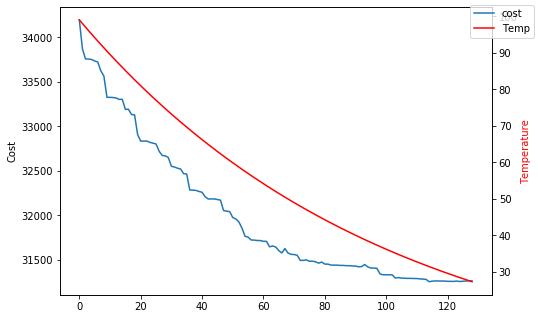

Cost Value after Stage [31263.81061453]
Training_input (1350, 2080) Training_output 1350 no.iterations= 134


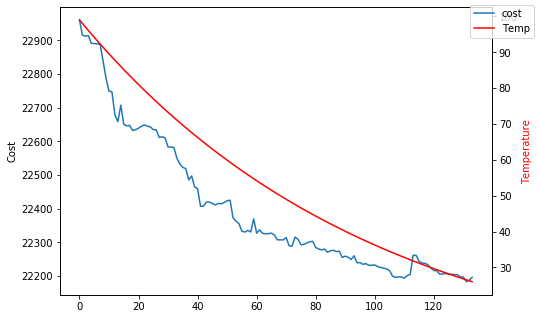

Cost Value after Stage 22182.355304782184
Training_input (1090, 2080) Training_output 1090 no.iterations= 108


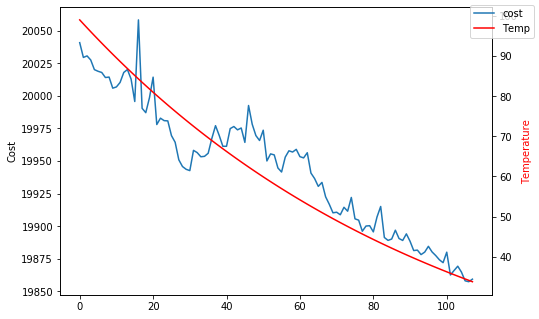

Cost Value after Stage 19858.076400815906
Total Execution Time: 327.7181587219238


In [8]:
Uniform_Scurr,Uniform_Tcurr,Uniform_Ccurr=callStage(uniform,1000,10)

[54, 11, 59, 14, 10, 28, 27, 47, 60, 29, 56, 32, 9, 21, 40, 0, 44, 34, 7, 43, 36, 16, 63, 12, 4, 1, 39, 23, 33, 53, 49, 37, 62, 51, 15, 13, 20, 25, 52, 3, 42, 26, 55, 58, 5, 17, 50, 41, 24, 57, 22, 35, 18, 30, 31, 45, 19, 61, 2, 6, 38, 8, 48, 46]


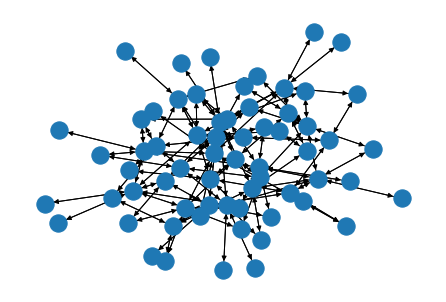

In [14]:
Noc_uni1=nx.from_numpy_matrix(Uniform_Scurr,create_using=nx.DiGraph())
nx.draw(Noc_uni1,node=True)
print (Uniform_Tcurr)

Cost function for Mesh 10052.9357927789
Training_input (1000, 2080) Training_output 1000 no.iterations= 99


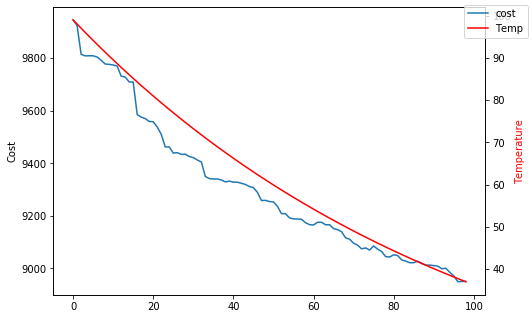

Cost Value after Stage 8949.061572250279
Training_input (300, 2080) Training_output 300 no.iterations= 29


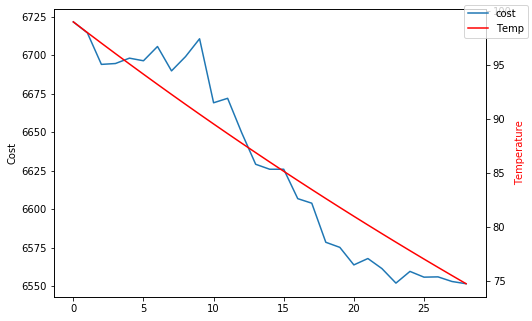

Cost Value after Stage [6553.93203586]
Training_input (570, 2080) Training_output 570 no.iterations= 56


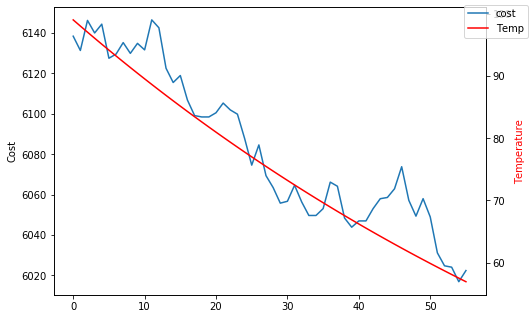

Cost Value after Stage [6021.66531961]
Total Execution Time: 179.10574293136597


In [10]:
Complement_Scurr,Complement_Tcurr,Complement_Ccurr=callStage(complement,1000,10)

[37, 61, 33, 24, 45, 6, 35, 11, 43, 0, 2, 29, 58, 18, 39, 22, 7, 62, 4, 50, 10, 48, 31, 55, 53, 59, 14, 28, 23, 21, 46, 30, 20, 54, 8, 5, 38, 3, 1, 47, 15, 44, 57, 63, 51, 60, 12, 32, 52, 19, 13, 56, 16, 34, 27, 25, 17, 40, 36, 9, 42, 49, 26, 41]


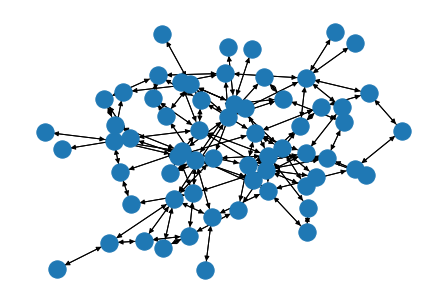

In [15]:
Noc_com1=nx.from_numpy_matrix(Complement_Scurr,create_using=nx.DiGraph())
nx.draw(Noc_com1,node=True)
print (Complement_Tcurr)